In [1]:
# run in a notebook cell with ! prefix if needed
!pip install scikit-learn xgboost shap joblib matplotlib seaborn

   ---------------------------------------- 0.0/149.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/149.9 MB 6.3 MB/s eta 0:00:24
    --------------------------------------- 2.9/149.9 MB 7.6 MB/s eta 0:00:20
   - -------------------------------------- 6.0/149.9 MB 10.0 MB/s eta 0:00:15
   -- ------------------------------------- 9.7/149.9 MB 11.9 MB/s eta 0:00:12
   --- ------------------------------------ 13.6/149.9 MB 13.6 MB/s eta 0:00:11
   ---- ----------------------------------- 16.5/149.9 MB 13.9 MB/s eta 0:00:10
   ----- ---------------------------------- 20.2/149.9 MB 14.0 MB/s eta 0:00:10
   ------ --------------------------------- 23.9/149.9 MB 14.1 MB/s eta 0:00:09
   ------- -------------------------------- 27.0/149.9 MB 14.3 MB/s eta 0:00:09
   -------- ------------------------------- 31.2/149.9 MB 14.7 MB/s eta 0:00:09
   -------- ------------------------------- 33.0/149.9 MB 14.4 MB/s eta 0:00:09
   -------- ------------------------------- 33.6/149.9 

In [3]:
import pandas as pd
import numpy as np

# sklearn & helpers
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, precision_recall_fscore_support)
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv('telco_cleaned.csv')   # <- change path if needed
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,CLTV
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,29.85
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.50,No,1936.30
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,107.70
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,1903.50
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,141.40


In [5]:
# basic shape & dtypes
print(df.shape)
display(df.dtypes.value_counts())
display(df.isnull().sum().sort_values(ascending=False).head(20))

# churn distribution
print(df['Churn'].value_counts())
print(df['Churn'].value_counts(normalize=True))

# convert target to 0/1 if needed
df['Churn'] = df['Churn'].map({'No':0, 'Yes':1})

(7032, 22)


object     17
float64     3
int64       2
Name: count, dtype: int64

customerID          0
gender              0
Churn               0
TotalCharges        0
MonthlyCharges      0
PaymentMethod       0
PaperlessBilling    0
Contract            0
StreamingMovies     0
StreamingTV         0
TechSupport         0
DeviceProtection    0
OnlineBackup        0
OnlineSecurity      0
InternetService     0
MultipleLines       0
PhoneService        0
tenure              0
Dependents          0
Partner             0
dtype: int64

Churn
No     5163
Yes    1869
Name: count, dtype: int64
Churn
No     0.734215
Yes    0.265785
Name: proportion, dtype: float64


In [7]:
display(df.describe().T)
display(df.sample(5))

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
MonthlyCharges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
TotalCharges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80
Churn,7032.0,0.265785,0.441782,0.00,0.0000,0.000,1.0000,1.00
CLTV,7032.0,2283.147248,2264.703327,18.80,397.8000,1394.575,3791.2500,8550.00


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,CLTV
6169,3719-TDVQB,Female,1,Yes,No,54,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,Yes,Mailed check,18.95,1031.10,0,1023.30
472,1304-BCCFO,Male,0,Yes,No,9,Yes,No,DSL,No,...,No,Yes,Yes,Month-to-month,Yes,Mailed check,70.05,564.40,0,630.45
2211,8495-LJDFO,Female,1,No,No,64,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),108.95,7111.30,0,6972.80
2480,9921-ZVRHG,Female,0,No,No,14,Yes,Yes,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,80.45,1072.00,1,1126.30
919,8942-DBMHZ,Male,0,No,No,12,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Month-to-month,No,Mailed check,20.45,255.35,0,245.40


In [9]:
# drop id if present
if 'customerID' in df.columns:
    df = df.drop(columns=['customerID'])

# auto-select columns
target = 'Churn'
X = df.drop(columns=[target])
y = df[target]

# numeric vs categorical
num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()
print("Numeric:", num_cols)
print("Categorical:", cat_cols)

# Example feature engineering (optional)
# create tenure group
if 'tenure' in X.columns:
    X['tenure_group'] = pd.cut(X['tenure'], bins=[-1,6,12,24,48,72], labels=['0-6','7-12','13-24','25-48','49-72'])
    cat_cols.append('tenure_group')


Numeric: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'CLTV']
Categorical: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


In [23]:
import sklearn
from packaging import version

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='MISSING')),
    ('onehot', ohe)
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(X_train.shape, X_test.shape, y_train.mean(), y_test.mean())

(5625, 21) (1407, 21) 0.2657777777777778 0.2658137882018479


In [27]:
pipe_log = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# quick CV score (Stratified K-Fold)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipe_log, X_train, y_train, cv=cv, scoring='roc_auc')
print("Logistic CV ROC AUC:", cv_scores.mean(), cv_scores)
# fit and evaluate on test
pipe_log.fit(X_train, y_train)
y_pred = pipe_log.predict(X_test)
y_proba = pipe_log.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))

Logistic CV ROC AUC: 0.848447204968944 [0.84391879 0.84605262 0.84245913 0.85011175 0.85969373]
              precision    recall  f1-score   support

           0       0.91      0.71      0.79      1033
           1       0.50      0.81      0.62       374

    accuracy                           0.73      1407
   macro avg       0.70      0.76      0.71      1407
weighted avg       0.80      0.73      0.75      1407

Test ROC AUC: 0.836964399418132


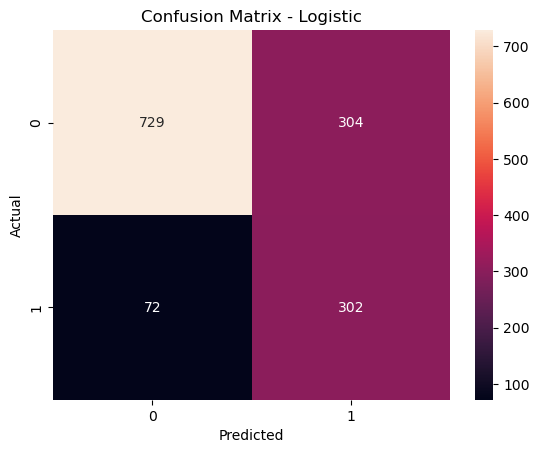

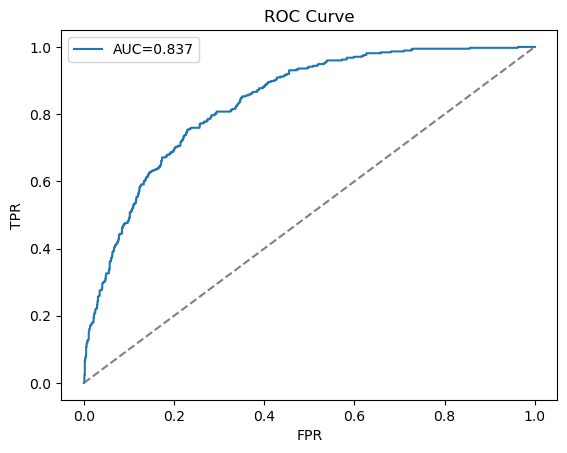

In [29]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.title('Confusion Matrix - Logistic')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

# ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('ROC Curve'); plt.legend(); plt.show()

In [31]:
pipe_rf = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])

param_grid = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [6, 10, None],
    'clf__min_samples_split': [2, 6],
    'clf__class_weight': ['balanced']
}

grid = GridSearchCV(pipe_rf, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
print("Best params:", grid.best_params_)
print("Best CV AUC:", grid.best_score_)

best_rf = grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred_rf))
print("RF Test ROC AUC:", roc_auc_score(y_test, y_proba_rf))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best params: {'clf__class_weight': 'balanced', 'clf__max_depth': 6, 'clf__min_samples_split': 6, 'clf__n_estimators': 200}
Best CV AUC: 0.8484148128952846
              precision    recall  f1-score   support

           0       0.91      0.72      0.80      1033
           1       0.51      0.79      0.62       374

    accuracy                           0.74      1407
   macro avg       0.71      0.76      0.71      1407
weighted avg       0.80      0.74      0.76      1407

RF Test ROC AUC: 0.8391968773780744


In [33]:
# example with imblearn
!pip install imbalanced-learn
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

imb_pipe = ImbPipeline([
    ('pre', preprocessor),
    ('smote', SMOTE(random_state=42)),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1))
])
imb_pipe.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'CLTV']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown=...
                                                                                 sparse_output=False))]),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_group'])])),
                ('smote', SMOTE(random_state=42)),
                ('clf', RandomForestClassifier(n_jobs=-1, random_state=42))])

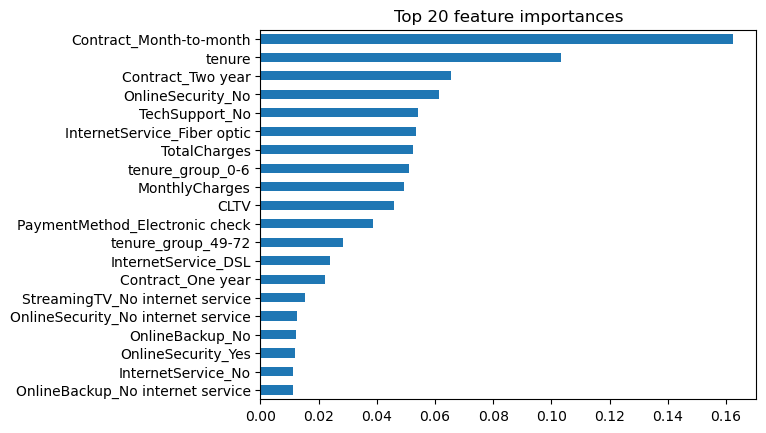

In [47]:
# Feature names extraction helper
ohe = grid.best_estimator_.named_steps['pre'].named_transformers_['cat'].named_steps['onehot']
cat_ohe_cols = ohe.get_feature_names_out(cat_cols)
feature_names = num_cols + list(cat_ohe_cols)

# If RandomForest
rf = best_rf.named_steps['clf']
importances = rf.feature_importances_
fi = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(20)
fi.plot(kind='barh'); plt.gca().invert_yaxis(); plt.title('Top 20 feature importances'); plt.show()

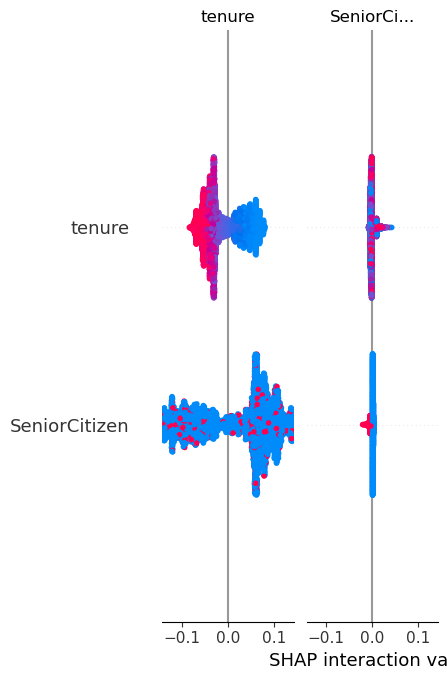

In [53]:
import shap

explainer = shap.TreeExplainer(rf)
X_train_trans = best_rf.named_steps['pre'].transform(X_train)
shap_values = explainer.shap_values(X_train_trans)

# Since shap_values is an ndarray, use it directly (no [1])
shap.summary_plot(shap_values, X_train_trans, feature_names=feature_names)

In [59]:
# Save
joblib.dump(best_rf, 'churn_rf_pipeline.joblib')
import joblib

best_rf_loaded = joblib.load('churn_rf_pipeline.joblib')

# Predictions CSV for dashboards
pred_df = X_test.copy()
pred_df['y_true'] = y_test.values
pred_df['y_pred'] = y_pred_rf
pred_df['churn_proba'] = y_proba_rf
pred_df.to_csv('churn_predictions_for_dashboard.csv', index=False)

In [99]:
pip install scikit-learn==1.5.1 joblib==1.4.2

Note: you may need to restart the kernel to use updated packages.


In [103]:
import joblib
joblib.load('churn_rf_pipeline.joblib')

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges', 'CLTV']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown=...
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod',
                                                   'tenure_group'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=6,
                                        min_samples_split=6, n_estimators=200,
                                        n_jobs=-1, random_state=42))])